# A simple 1D model implementation


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.configuration.no_transport import (
    ForcingParameter,
    ForcingUnit,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
    MigratoryTypeParameter,
    NoTransportConfiguration,
)
from seapopym.configuration.no_transport.environment_parameter import ChunkParameter, EnvironmentParameter
from seapopym.model import NoTransportModel
from seapopym.standard import coordinates
from seapopym.standard.units import StandardUnitsLabels


## Generating data for the 1D simulation

Let's generate some data for the 1D simulation. In this NoTransport model, only temperature and primary production are required. The temperature is generated as a sine wave with a period of 1 year and the primary production is randomly generated.


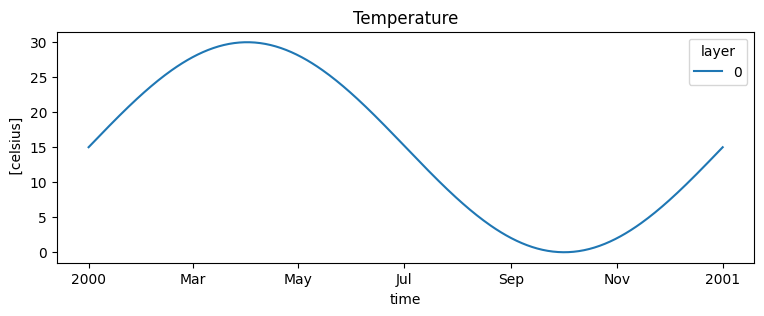

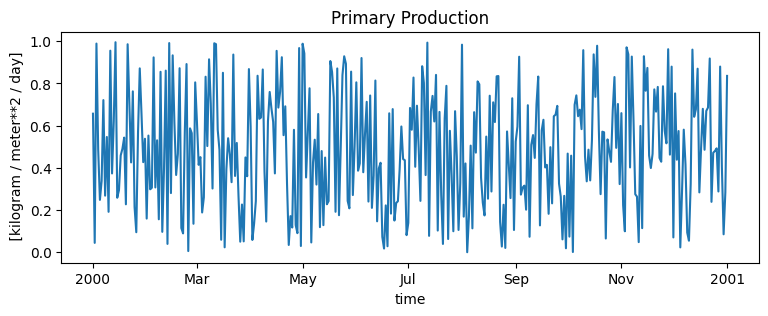

In [2]:
time_axis = coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D"))
n = int(time_axis.size)
t = np.linspace(0, 1, n)
temperature = 15 + 15 * np.sin(2 * np.pi * t)
primary_production = 10 + 5 * np.sin(2 * np.pi * t * 365)

temperature = xr.DataArray(
    dims=["time", "latitude", "longitude", "layer"],
    coords={
        "time": coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "latitude": coordinates.new_latitude([0]),
        "longitude": coordinates.new_longitude([0]),
        "layer": coordinates.new_layer([0]),
    },
    attrs={"units": StandardUnitsLabels.temperature},
    data=temperature[:, np.newaxis, np.newaxis, np.newaxis],
)

plt.figure(figsize=(9, 3))
temperature[:, 0, 0].cf.plot.line(x="T")
plt.title("Temperature")
plt.show()

primary_production = xr.DataArray(
    dims=["time", "latitude", "longitude"],
    coords={
        "time": coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "latitude": coordinates.new_latitude([0]),
        "longitude": coordinates.new_longitude([0]),
    },
    attrs={"units": StandardUnitsLabels.production},
    data=np.random.rand(367, 1, 1),
)

plt.figure(figsize=(9, 3))
primary_production.plot()
plt.title("Primary Production")
plt.show()

dataset = xr.Dataset({"temperature": temperature, "primary_production": primary_production})

## Initialize the model

First we set up the model parameters. We will define a single functional group with the commonly used parameters for the zooplankton in Seapodym LMTL.


In [3]:
day_layer = 0
night_layer = 0
tr_0 = 10.38
gamma_tr = -0.11
lambda_temperature_0 = 1 / 150
gamma_lambda_temperature = 0.15

f_groups = FunctionalGroupParameter(
    functional_group=[
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}",
            energy_transfert=0.1668,
            migratory_type=MigratoryTypeParameter(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalTypeParameter(
                lambda_temperature_0=lambda_temperature_0,
                gamma_lambda_temperature=gamma_lambda_temperature,
                tr_0=tr_0,
                gamma_tr=gamma_tr,
            ),
        ),
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}_BIS",
            energy_transfert=0.1668 / 2,
            migratory_type=MigratoryTypeParameter(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalTypeParameter(
                lambda_temperature_0=lambda_temperature_0 / 2,
                gamma_lambda_temperature=gamma_lambda_temperature / 2,
                tr_0=tr_0 / 2,
                gamma_tr=gamma_tr / 2,
            ),
        ),
    ]
)

p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"]),
    primary_production=ForcingUnit(forcing=dataset["primary_production"]),
)

parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups)
no_transport_model = NoTransportModel.from_configuration(configuration=parameters)
no_transport_model.state

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:280: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'cohort' ('cohort',) The recommendation is to set join explicitly for this case.
  return xr.concat(all_dataset, dim=coordinates)
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:280: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_n

<xarray.Dataset> Size: 10kB
Dimensions:                     (time: 367, latitude: 1, longitude: 1,
                                 layer: 1, functional_group: 2, cohort: 11)
Coordinates:
  * time                        (time) datetime64[ns] 3kB 2000-01-01 ... 2001...
  * latitude                    (latitude) int64 8B 0
  * longitude                   (longitude) int64 8B 0
  * layer                       (layer) int64 8B 0
  * cohort                      (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * functional_group            (functional_group) int64 16B 0 1
Data variables: (12/18)
    temperature                 (time, latitude, longitude, layer) float64 3kB ...
    primary_production          (time, latitude, longitude) float64 3kB 0.656...
    name                        (functional_group) <U8 64B 'D0N0' 'D0N0_BIS'
    energy_transfert            (functional_group) float64 16B 0.1668 0.0834
    lambda_temperature_0        (functional_group) float64 16B 0.006667 0.003333
    gamma_lambda_temperature    (functional_group) float64 16B 0.15 0.075
    ...                          ...
    max_timestep                (functional_group, cohort) float64 176B 1.0 ....
    mean_timestep               (functional_group, cohort) float64 176B 1.0 ....
    timestep                    float64 8B 1.0
    angle_horizon_sun           float64 8B 0.0
    compute_initial_conditions  bool 1B False
    compute_preproduction       bool 1B False

In [4]:
no_transport_model.expected_memory_usage

'The expected memory usage is 0.05 MB.'

## Run the model


In [5]:
no_transport_model.run()
no_transport_model.state

<xarray.Dataset> Size: 50kB
Dimensions:                       (time: 367, latitude: 1, longitude: 1,
                                   functional_group: 2, cohort: 11, layer: 1)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2000-01-01 ... 20...
  * latitude                      (latitude) int64 8B 0
  * longitude                     (longitude) int64 8B 0
  * functional_group              (functional_group) int64 16B 0 1
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * layer                         (layer) int64 8B 0
Data variables: (12/28)
    biomass                       (functional_group, time, latitude, longitude) float64 6kB ...
    recruited                     (functional_group, time, latitude, longitude) float64 6kB ...
    mortality_field               (functional_group, time, latitude, longitude) float64 6kB ...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 8kB ...
    min_temperature               (functional_group, cohort) float64 176B 21....
    primary_production_by_fgroup  (functional_group, time, latitude, longitude) float64 6kB ...
    ...                            ...
    max_timestep                  (functional_group, cohort) float64 176B 1.0...
    mean_timestep                 (functional_group, cohort) float64 176B 1.0...
    timestep                      float64 8B 1.0
    angle_horizon_sun             float64 8B 0.0
    compute_initial_conditions    bool 1B False
    compute_preproduction         bool 1B False

## Plotting the results

### The biomass evolution over time


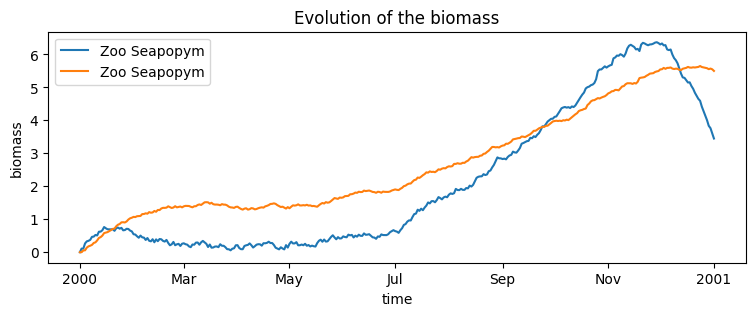

In [6]:
plt.figure(figsize=(9, 3))
no_transport_model.state["biomass"].mean(["latitude", "longitude"]).plot(
    label="Zoo Seapopym", x="time", hue="functional_group"
)
plt.legend()
plt.title("Evolution of the biomass")
plt.show()

## And now let's do it in parallel


In [7]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55192,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:55206,Total threads: 3
Dashboard: http://127.0.0.1:55211/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:55195,


In [8]:
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"]),
    primary_production=ForcingUnit(forcing=dataset["primary_production"]),
)
environment = EnvironmentParameter(chunk=ChunkParameter())

In [9]:
parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups, environment=environment)
no_transport_model = NoTransportModel.from_configuration(configuration=parameters)
no_transport_model.state

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:280: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'cohort' ('cohort',) The recommendation is to set join explicitly for this case.
  return xr.concat(all_dataset, dim=coordinates)
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:280: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_n

<xarray.Dataset> Size: 10kB
Dimensions:                     (time: 367, latitude: 1, longitude: 1,
                                 layer: 1, functional_group: 2, cohort: 11)
Coordinates:
  * time                        (time) datetime64[ns] 3kB 2000-01-01 ... 2001...
  * latitude                    (latitude) int64 8B 0
  * longitude                   (longitude) int64 8B 0
  * layer                       (layer) int64 8B 0
  * cohort                      (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * functional_group            (functional_group) int64 16B 0 1
Data variables: (12/18)
    temperature                 (time, latitude, longitude, layer) float64 3kB dask.array<chunksize=(367, 1, 1, 1), meta=np.ndarray>
    primary_production          (time, latitude, longitude) float64 3kB dask.array<chunksize=(367, 1, 1), meta=np.ndarray>
    name                        (functional_group) <U8 64B dask.array<chunksize=(1,), meta=np.ndarray>
    energy_transfert            (functional_group) float64 16B dask.array<chunksize=(1,), meta=np.ndarray>
    lambda_temperature_0        (functional_group) float64 16B dask.array<chunksize=(1,), meta=np.ndarray>
    gamma_lambda_temperature    (functional_group) float64 16B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                          ...
    max_timestep                (functional_group, cohort) float64 176B dask.array<chunksize=(1, 11), meta=np.ndarray>
    mean_timestep               (functional_group, cohort) float64 176B dask.array<chunksize=(1, 11), meta=np.ndarray>
    timestep                    float64 8B 1.0
    angle_horizon_sun           float64 8B 0.0
    compute_initial_conditions  bool 1B False
    compute_preproduction       bool 1B False

In [10]:
no_transport_model.run()

In [11]:
no_transport_model.state

<xarray.Dataset> Size: 50kB
Dimensions:                       (functional_group: 2, time: 367, latitude: 1,
                                   longitude: 1, cohort: 11, layer: 1)
Coordinates:
  * functional_group              (functional_group) int64 16B 0 1
  * time                          (time) datetime64[ns] 3kB 2000-01-01 ... 20...
  * latitude                      (latitude) int64 8B 0
  * longitude                     (longitude) int64 8B 0
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * layer                         (layer) int64 8B 0
Data variables: (12/28)
    biomass                       (functional_group, time, latitude, longitude) float64 6kB dask.array<chunksize=(1, 367, 1, 1), meta=np.ndarray>
    recruited                     (functional_group, time, latitude, longitude) float64 6kB dask.array<chunksize=(1, 367, 1, 1), meta=np.ndarray>
    mortality_field               (functional_group, time, latitude, longitude) float64 6kB dask.array<chunksize=(1, 367, 1, 1), meta=np.ndarray>
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 8kB dask.array<chunksize=(1, 367, 1, 1, 11), meta=np.ndarray>
    min_temperature               (functional_group, cohort) float64 176B dask.array<chunksize=(1, 11), meta=np.ndarray>
    primary_production_by_fgroup  (functional_group, time, latitude, longitude) float64 6kB dask.array<chunksize=(1, 367, 1, 1), meta=np.ndarray>
    ...                            ...
    max_timestep                  (functional_group, cohort) float64 176B dask.array<chunksize=(1, 11), meta=np.ndarray>
    mean_timestep                 (functional_group, cohort) float64 176B dask.array<chunksize=(1, 11), meta=np.ndarray>
    timestep                      float64 8B 1.0
    angle_horizon_sun             float64 8B 0.0
    compute_initial_conditions    bool 1B False
    compute_preproduction         bool 1B False

### The biomass evolution over time


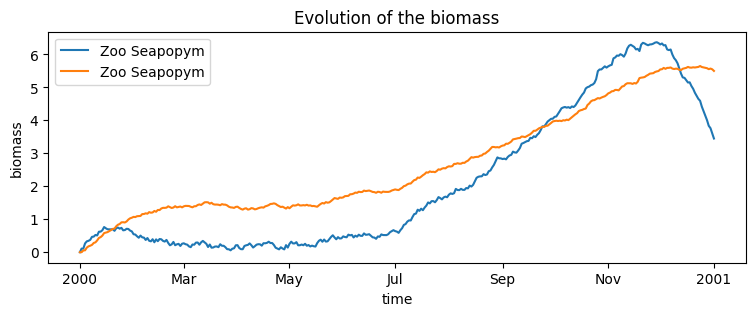

In [12]:
plt.figure(figsize=(9, 3))
no_transport_model.state["biomass"].mean(["latitude", "longitude"]).plot(
    label="Zoo Seapopym", x="time", hue="functional_group"
)
plt.legend()
plt.title("Evolution of the biomass")
plt.show()

## Finaly, let's try in weekly time step


In [13]:
weekly_dataset = dataset.resample(time="1W").mean().interpolate_na()
weekly_dataset

<xarray.Dataset> Size: 1kB
Dimensions:             (latitude: 1, longitude: 1, layer: 1, time: 54)
Coordinates:
  * latitude            (latitude) int64 8B 0
  * longitude           (longitude) int64 8B 0
  * layer               (layer) int64 8B 0
  * time                (time) datetime64[ns] 432B 2000-01-02 ... 2001-01-07
Data variables:
    temperature         (time, latitude, longitude, layer) float64 432B 15.13...
    primary_production  (time, latitude, longitude) float64 432B 0.3506 ... 0...

In [14]:
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=weekly_dataset["temperature"]),
    primary_production=ForcingUnit(forcing=weekly_dataset["primary_production"]),
)
parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups, environment=environment)
no_transport_model = NoTransportModel.from_configuration(configuration=parameters)
no_transport_model.state

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:280: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'cohort' ('cohort',) The recommendation is to set join explicitly for this case.
  return xr.concat(all_dataset, dim=coordinates)
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:280: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_n

<xarray.Dataset> Size: 2kB
Dimensions:                     (time: 54, latitude: 1, longitude: 1, layer: 1,
                                 functional_group: 2, cohort: 2)
Coordinates:
  * latitude                    (latitude) int64 8B 0
  * longitude                   (longitude) int64 8B 0
  * layer                       (layer) int64 8B 0
  * time                        (time) datetime64[ns] 432B 2000-01-02 ... 200...
  * cohort                      (cohort) int64 16B 0 1
  * functional_group            (functional_group) int64 16B 0 1
Data variables: (12/18)
    temperature                 (time, latitude, longitude, layer) float64 432B dask.array<chunksize=(54, 1, 1, 1), meta=np.ndarray>
    primary_production          (time, latitude, longitude) float64 432B dask.array<chunksize=(54, 1, 1), meta=np.ndarray>
    name                        (functional_group) <U8 64B dask.array<chunksize=(1,), meta=np.ndarray>
    energy_transfert            (functional_group) float64 16B dask.array<chunksize=(1,), meta=np.ndarray>
    lambda_temperature_0        (functional_group) float64 16B dask.array<chunksize=(1,), meta=np.ndarray>
    gamma_lambda_temperature    (functional_group) float64 16B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                          ...
    max_timestep                (functional_group, cohort) float64 32B dask.array<chunksize=(1, 2), meta=np.ndarray>
    mean_timestep               (functional_group, cohort) float64 32B dask.array<chunksize=(1, 2), meta=np.ndarray>
    timestep                    float64 8B 7.0
    angle_horizon_sun           float64 8B 0.0
    compute_initial_conditions  bool 1B False
    compute_preproduction       bool 1B False

### Run the model


In [15]:
no_transport_model.run()
no_transport_model.state

<xarray.Dataset> Size: 7kB
Dimensions:                       (functional_group: 2, time: 54, latitude: 1,
                                   longitude: 1, cohort: 2, layer: 1)
Coordinates:
  * functional_group              (functional_group) int64 16B 0 1
  * time                          (time) datetime64[ns] 432B 2000-01-02 ... 2...
  * latitude                      (latitude) int64 8B 0
  * longitude                     (longitude) int64 8B 0
  * cohort                        (cohort) int64 16B 0 1
  * layer                         (layer) int64 8B 0
Data variables: (12/28)
    biomass                       (functional_group, time, latitude, longitude) float64 864B dask.array<chunksize=(1, 54, 1, 1), meta=np.ndarray>
    recruited                     (functional_group, time, latitude, longitude) float64 864B dask.array<chunksize=(1, 54, 1, 1), meta=np.ndarray>
    mortality_field               (functional_group, time, latitude, longitude) float64 864B dask.array<chunksize=(1, 54, 1, 1), meta=np.ndarray>
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 216B dask.array<chunksize=(1, 54, 1, 1, 2), meta=np.ndarray>
    min_temperature               (functional_group, cohort) float64 32B dask.array<chunksize=(1, 2), meta=np.ndarray>
    primary_production_by_fgroup  (functional_group, time, latitude, longitude) float64 864B dask.array<chunksize=(1, 54, 1, 1), meta=np.ndarray>
    ...                            ...
    max_timestep                  (functional_group, cohort) float64 32B dask.array<chunksize=(1, 2), meta=np.ndarray>
    mean_timestep                 (functional_group, cohort) float64 32B dask.array<chunksize=(1, 2), meta=np.ndarray>
    timestep                      float64 8B 7.0
    angle_horizon_sun             float64 8B 0.0
    compute_initial_conditions    bool 1B False
    compute_preproduction         bool 1B False

### Plotting the results

#### The biomass evolution over time


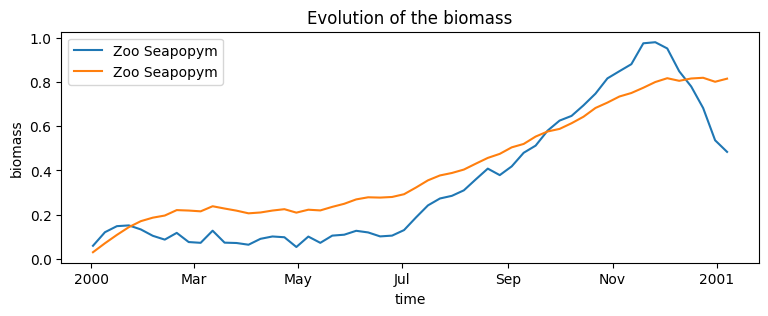

In [16]:
plt.figure(figsize=(9, 3))
no_transport_model.state["biomass"].mean(["latitude", "longitude"]).plot(
    label="Zoo Seapopym", x="time", hue="functional_group"
)
plt.legend()
plt.title("Evolution of the biomass")
plt.show()